In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/brandonmanley/Desktop/PhD/oam_pheno/dijet_dsa')
import dsa_mc.dijet as dijet
import random
from IPython.display import display, Math

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [43]:
# get spectra of dsa

values = {}
values['pT'] = np.linspace(1, 50, 100)
values['s'] = np.linspace(100, 300, 100)
values['Q'] = np.linspace(4, 10, 100)

def get_base_kins():
    base_kins = dijet.Kinematics(Q=8, z=0.4, x=0.01, s=100**2, pT=30.0, delta=0.0, phi_Dp=0.0, phi_kp=0.0)
    base_kins.y = (base_kins.Q**2)/(base_kins.s*base_kins.x)
    assert base_kins.y <= 1, 'y > 1'
    return base_kins

kins = get_base_kins()

djs = {}
djs['dis+sidis'] = dijet.DIJET()
djs['+pp'] = dijet.DIJET()
djs['+pp'].load_params('replica_params_pp.csv')

denom = {}
num = {}

fits = ['dis+sidis', '+pp']
vars = ['pT', 's', 'Q']


for var in vars: 
    denom[var] = []
    
for fit in fits:
    num[fit] = {}
    for var in vars:
        num[fit][var] = []


nreps = 200
for irep in range(1, nreps):
    # if irep > 100: break
    print(irep)

    for ifit, fit in enumerate(fits):
        djs[fit].set_params(irep)
        
        for var in vars:
            num_rep = []
            kins = get_base_kins()
            
            for ivalue in values[var]:
                if var == 'pT': kins.pT = ivalue
                elif var == 's': 
                    kins.s = ivalue**2
                    kins.y = (kins.Q**2)/(kins.s*kins.x)
                    assert kins.y <= 1, 'y > 1'
                elif var == 'Q':
                    kins.Q = ivalue
                    kins.y = (kins.Q**2)/(kins.s*kins.x)
                    assert kins.y <= 1, 'y > 1'
                else: 
                    raise ValueError(f'variable {var} not recognized')

                if irep == 1 and ifit == 0:    
                    denom[var].append(djs[fit].angle_integrated_denominator(kins))
                num_rep.append(djs[fit].angle_integrated_numerator(kins)) 
                
            num[fit][var].append(num_rep)

    np.save('predictions/dsa_denom.npy', denom, allow_pickle=True)
    np.save('predictions/dsa_num.npy', num, allow_pickle=True)
    

loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-rc/
loaded params from replica_params_dis.csv
loaded random moment params from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/random_moment_params.csv
loaded replica 1
loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-rc/
loaded params from replica_params_dis.csv
loaded random moment params from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/random_moment_params.csv
loaded replica 1
loaded params from replica_params_pp.csv
loaded random moment params from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/random_moment_params.csv
1
loaded replica 1
loaded replica 1
2
loaded replica 2
load

In [45]:
# load reps and calc bands for numerator

num_data = np.load('predictions/dsa_num.npy', allow_pickle=True).item()
denom_data = np.load('predictions/dsa_denom.npy', allow_pickle=True).item()

confid = 68
num_bands = {}
ratio_bands = {}

fits = ['dis+sidis', '+pp']
vars = ['pT', 's', 'Q']

for fit in fits:
    num_bands[fit] = {}
    ratio_bands[fit] = {}
    
    for obj in ['lower', 'upper', 'mean']:
        num_bands[fit][obj] = {}
        ratio_bands[fit][obj] = {}


    for var in vars:
        num_bands[fit]['lower'][var] = np.percentile(np.abs(num_data[fit][var]), 0.5*(100-confid), axis=0)
        num_bands[fit]['upper'][var] = np.percentile(np.abs(num_data[fit][var]), 100 - 0.5*(100-confid), axis=0)
        num_bands[fit]['mean'][var] = np.mean(np.abs(num_data[fit][var]), axis=0)

        ratio_bands[fit]['lower'][var] = np.percentile(np.array(num_data[fit][var])/np.array(denom_data[var]), 0.5*(100-confid), axis=0)
        ratio_bands[fit]['upper'][var] = np.percentile(np.array(num_data[fit][var])/np.array(denom_data[var]), 100 - 0.5*(100-confid), axis=0)
        ratio_bands[fit]['mean'][var] = np.mean(np.array(num_data[fit][var])/np.array(denom_data[var]), axis=0)
        


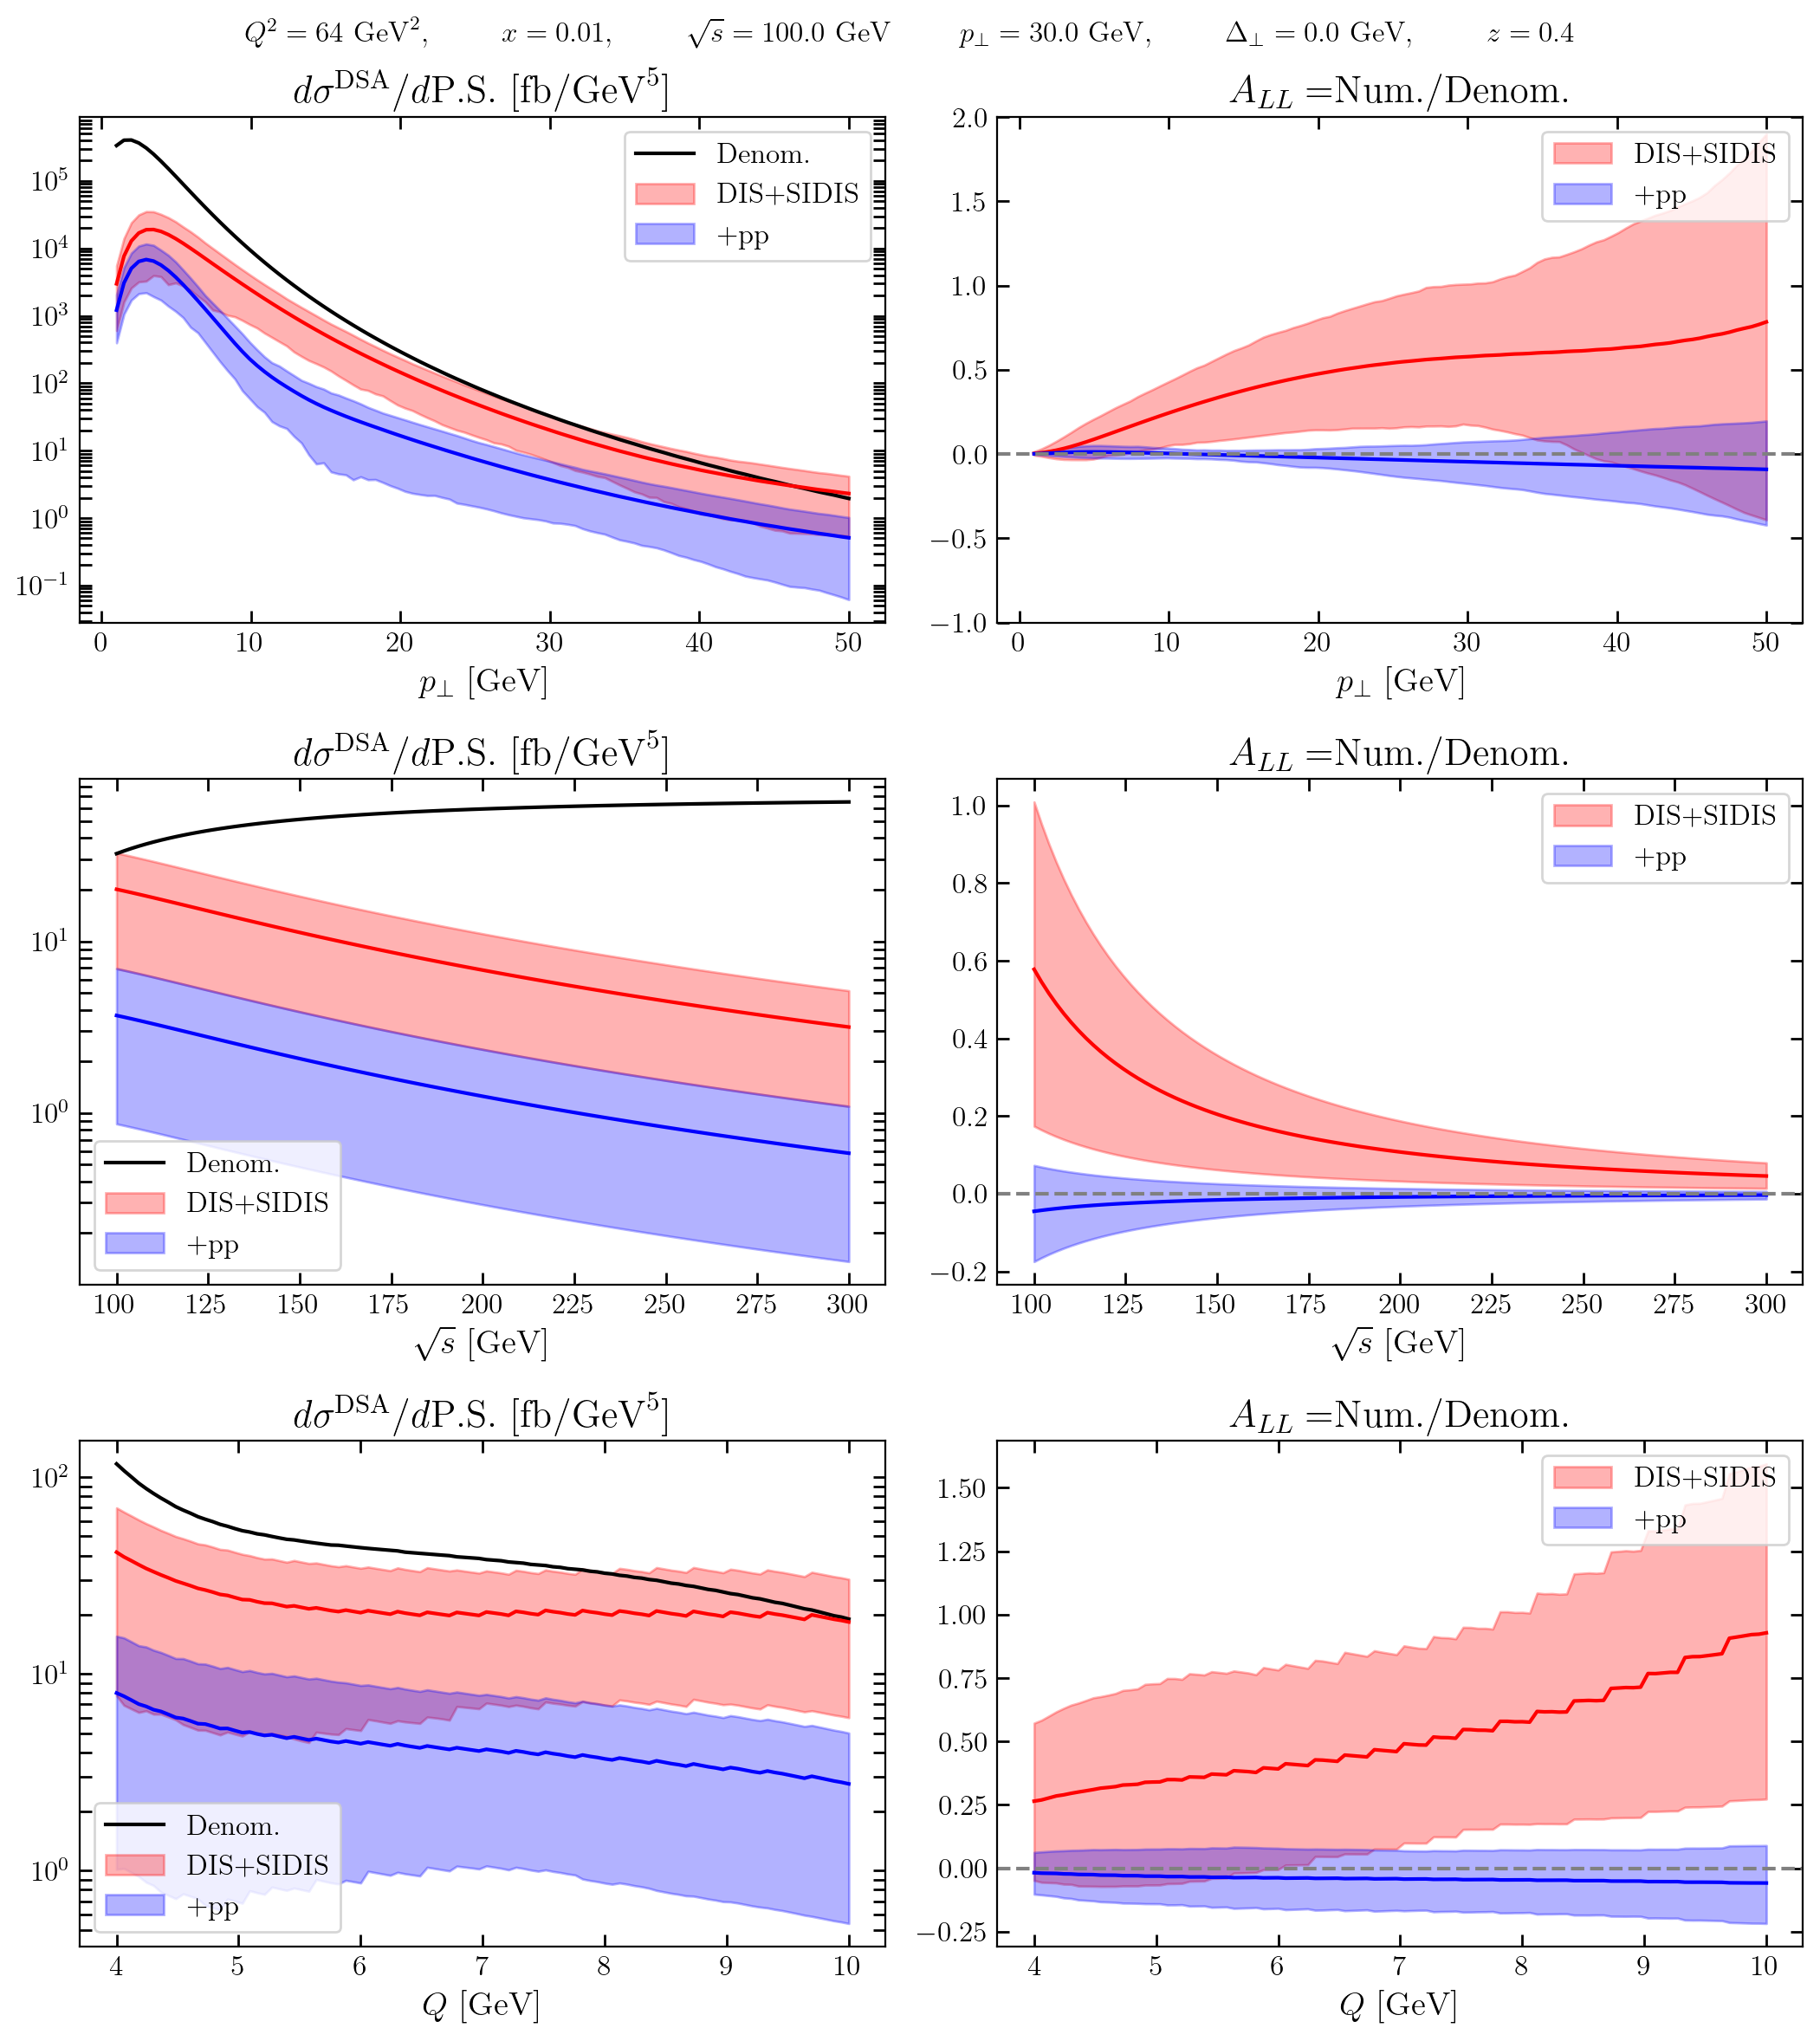

In [49]:
# plot spectra

asp_ratio = 4/3
psize = 4
fig, axs = plt.subplots(3, 2, figsize=(asp_ratio*psize*2, psize*3))

base_kins = get_base_kins()
base_str = fr'$Q^2={round(base_kins.Q**2,1)} \,\, \mathrm{{GeV}}^2, \hspace{{1cm}} x={base_kins.x}, \hspace{{1cm}}\sqrt{{s}}={np.sqrt(base_kins.s)} \,\, \mathrm{{GeV}}$'
base_str += fr'$\hspace{{1cm}} p_\perp ={base_kins.pT}\,\, \mathrm{{GeV}}, \hspace{{1cm}} \Delta_\perp ={base_kins.delta}\,\, \mathrm{{GeV}}, \hspace{{1cm}} z={base_kins.z}$'
fig.suptitle(base_str, fontsize=12)

plot_bands = True
colors = ['red', 'blue']
labels = ['DIS+SIDIS', '+pp']

for ivar, var in enumerate(vars):
    
    axs[ivar,0].plot(values[var], denom_data[var], label = 'Denom.', color='black')

    for ifit, fit in enumerate(fits):
        # if ifit > 0: continue

        if plot_bands: 
            axs[ivar,0].plot(values[var], num_bands[fit]['mean'][var], color=colors[ifit])
            axs[ivar,0].fill_between(values[var], num_bands[fit]['lower'][var], num_bands[fit]['upper'][var], color=colors[ifit], alpha=0.3, label=labels[ifit])

            axs[ivar,1].plot(values[var], ratio_bands[fit]['mean'][var], color=colors[ifit])
            axs[ivar,1].fill_between(values[var], ratio_bands[fit]['lower'][var], ratio_bands[fit]['upper'][var], color=colors[ifit], alpha=0.3, label=labels[ifit])

        else:
            for id, rep in enumerate(num_data[fit][var]):
                if id == 0:
                    axs[ivar,0].plot(values[var], np.abs(rep), color=colors[ifit], alpha=0.2, label=rf'$|\mathrm{{Num.}}|$ {labels[ifit]}')
                else:
                    axs[ivar,0].plot(values[var], np.abs(rep), color=colors[ifit], alpha=0.2)
    
                if id == 0:
                    axs[ivar,1].plot(values[var], np.array(rep)/np.array(denom_data[var]), color=colors[ifit], alpha=0.2, label=labels[ifit])
                else:
                    axs[ivar,1].plot(values[var], np.array(rep)/np.array(denom_data[var]), color=colors[ifit], alpha=0.2)

    
axs[0,0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0,0].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}/d \mathrm{{P.S.}} \,\,[\mathrm{{fb}}/ \mathrm{{GeV}}^5]$')
axs[0,0].legend()
axs[0,0].semilogy()
# ax.set_ylim([-0.000005, 0.000005])
axs[0,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[0,1].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0,1].set_title(fr'$A_{{LL}}=$Num./Denom.')
# axs[0,1].axhline(y=1, color='grey', linestyle=':')
axs[0,1].axhline(y=0, color='grey', linestyle='--')
# axs[0,1].axhline(y=-1, color='grey', linestyle=':')
# axs[1].semilogy()
axs[0,1].legend()
axs[0,1].set_ylim([-1, 2])
axs[0,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[1,0].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[1,0].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}/d \mathrm{{P.S.}} \,\,[\mathrm{{fb}}/ \mathrm{{GeV}}^5]$')
axs[1,0].legend()
axs[1,0].semilogy()
# ax.set_ylim([-0.000005, 0.000005])
axs[1,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[1,1].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[1,1].set_title(fr'$A_{{LL}}=$Num./Denom.')
# axs[1,1].axhline(y=1, color='grey', linestyle=':')
axs[1,1].axhline(y=0, color='grey', linestyle='--')
# axs[1,1].axhline(y=-1, color='grey', linestyle=':')
# axs[1].semilogy()
axs[1,1].legend()
# axs[1,1].set_ylim([-1.1, 1.1])
axs[1,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[2,0].set_xlabel(r'$Q$ [GeV]')
axs[2,0].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}/d \mathrm{{P.S.}} \,\,[\mathrm{{fb}}/ \mathrm{{GeV}}^5]$')
axs[2,0].legend()
axs[2,0].semilogy()
# ax.set_ylim([-0.000005, 0.000005])
axs[2,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[2,1].set_xlabel(r'$Q$ [GeV]')
axs[2,1].set_title(fr'$A_{{LL}}=$Num./Denom.')
# axs[2,1].axhline(y=1, color='grey', linestyle=':')
axs[2,1].axhline(y=0, color='grey', linestyle='--')
# axs[2,1].axhline(y=-1, color='grey', linestyle=':')
# axs[1].semilogy()
axs[2,1].legend()
# axs[2,1].set_ylim([-1.1, 1.1])
axs[2,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


plt.tight_layout()
plt.show()

if plot_bands:
    fig.savefig('plots/dsa_band.pdf', dpi=400, bbox_inches="tight")
else:
    fig.savefig('plots/dsa_lines.pdf', dpi=400, bbox_inches="tight")

